In [34]:
import copy
import time

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter

from data import artificial_1D_linear as data
from experiments.artificial_1D_linear.documentation import (
    plot_data_split,
    plot_predictions,
)
from models.DenseNetwork import DenseNetwork
from models.multi_output_net import MultiOutputNet
from utils.federated_learning import average_models
from utils.self_learning import combine_two

torch.manual_seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def get_logging_dir(name: str):
    return f"../../logs/artificial_1D_linear/{name}/{time.strftime('%m-%d-%H-%M-%S', time.localtime())}"

## Evaluating different learning algorithms on artifical 1D Dataset

Important Hyperparameters are set in the following:

In [36]:
BATCH_SIZE = 64

INPUT_FEATURES = 1
OUTPUT_FEATURES = 1
ARCHITECTURE = [12, 12, 12, 12]

LOSS_FN = torch.nn.MSELoss()

The training data gets split into a 20/80 test/training split randomly. The data is visualized in the following plot:

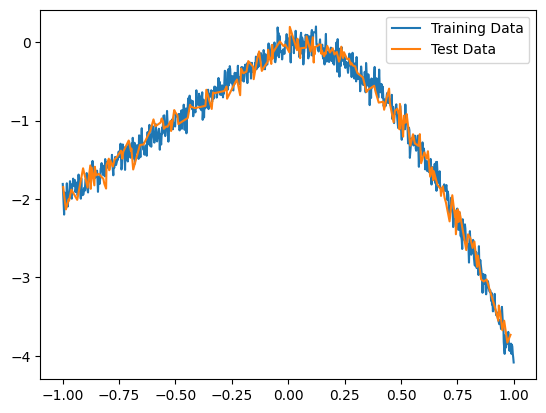

In [37]:
plt.plot(*data.get_data("train"), label="Training Data")
plt.plot(*data.get_data("test"), label="Test Data")
plt.legend()

In [38]:
def evaluate(model):
    model.eval()
    test_dataloader = data.get_dataloader("test")
    assert 1 == len(test_dataloader)

    for x, y in test_dataloader:
        return LOSS_FN(model(x), y).item()

### 1. Standard Batch-Gradient Descent

In [39]:
train_dataloader = data.get_dataloader("train", BATCH_SIZE, shuffle=True)

EPOCHS = 1000

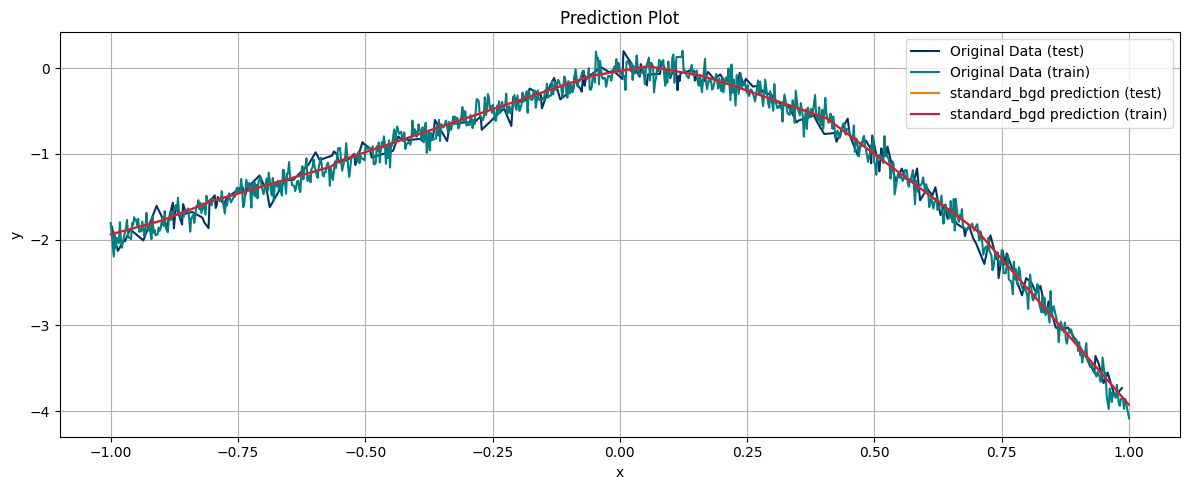

In [ ]:
dense_network = DenseNetwork(
    DenseNetwork.Config(INPUT_FEATURES, ARCHITECTURE, OUTPUT_FEATURES)
)
model_name = "standard_bgd"
optimizer = torch.optim.Adam(dense_network.parameters(), lr=0.001)


writer = SummaryWriter(get_logging_dir(model_name, "artificial_1D_linear"))


for e in range(EPOCHS):
    dense_network.train()
    losses = []
    for x, y in train_dataloader:
        optimizer.zero_grad()
        y_hat = dense_network(x)
        loss = LOSS_FN(y_hat, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    writer.add_scalar("loss", sum(losses) / len(losses), e)

    writer.add_scalar("test_loss", evaluate(dense_network), e)


plot_predictions(dense_network, model_name, writer)

writer.add_hparams(
    {
        "epochs": EPOCHS,
    },
    {
        "MSE Test": evaluate(dense_network),
    },
    run_name=".",
)

writer.close()

# 2. FedAvg

Now we want to solve the problem using FedAvg and 2 clients, to compare it to the novel method

In [45]:
NUM_CLIENTS = 10
CLIENT_IDs = range(NUM_CLIENTS)

SPLIT_TYPE = "interval"

COMMUNICATION_ROUNDS = 100
CLIENT_EPOCHS = 100

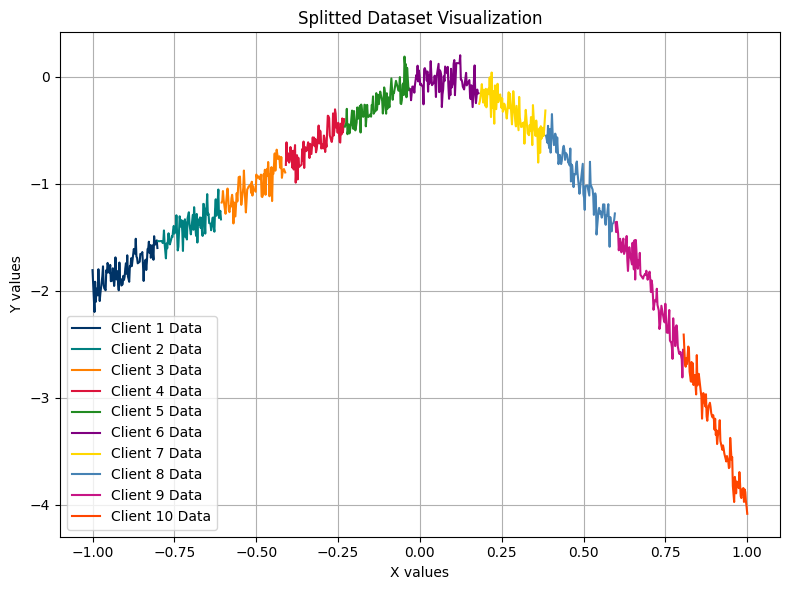

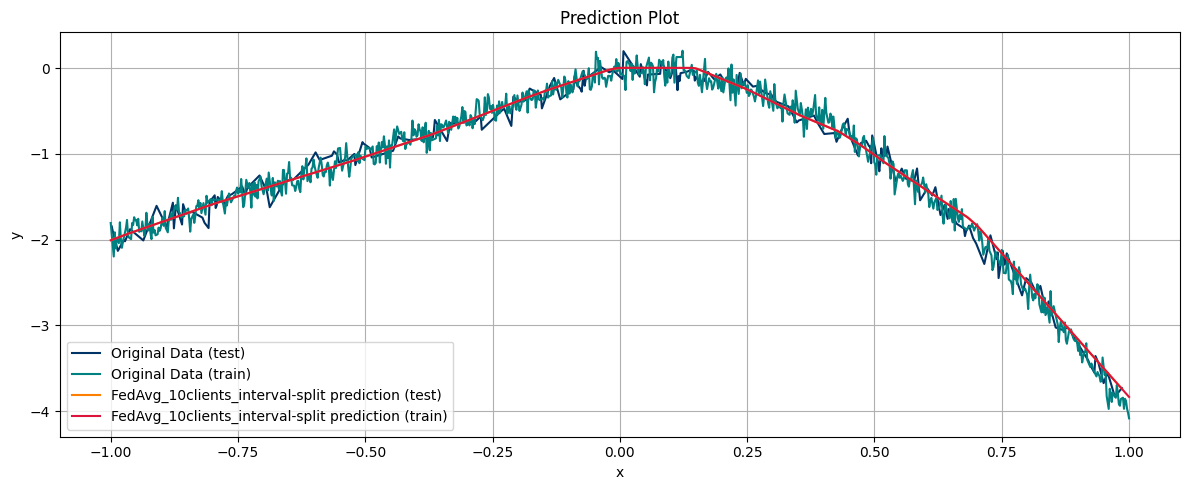

In [ ]:
model_name = f"FedAvg_{NUM_CLIENTS}clients_{SPLIT_TYPE}-split"
writer = SummaryWriter(get_logging_dir(model_name, "artificial_1D_linear"))


client_train_dataloaders = data.get_client_test_dataloaders(
    NUM_CLIENTS, SPLIT_TYPE, BATCH_SIZE, shuffle=True
)

plot_data_split(client_train_dataloaders, writer)


clients = [
    DenseNetwork(DenseNetwork.Config(INPUT_FEATURES, ARCHITECTURE, OUTPUT_FEATURES))
    for _ in CLIENT_IDs
]

client_optimizers = [
    torch.optim.Adam(clients[client_no].parameters(), lr=0.001)
    for client_no in CLIENT_IDs
]


for cr in range(COMMUNICATION_ROUNDS):
    for client_no, client in zip(CLIENT_IDs, clients):
        client.train()

        for ce in range(CLIENT_EPOCHS):
            losses = []
            for x, y in client_train_dataloaders[client_no]:
                client_optimizers[client_no].zero_grad()
                y_hat = client(x)
                loss = LOSS_FN(y_hat, y)
                loss.backward()
                client_optimizers[client_no].step()
                losses.append(loss.item())

            writer.add_scalar(
                f"loss/client{client_no}",
                sum(losses) / len(losses),
                cr * CLIENT_EPOCHS + ce,
            )

    for client, client_no in zip(clients, CLIENT_IDs):
        writer.add_scalar(f"test_loss/client{client_no}", evaluate(client), cr)

    global_model = average_models(clients)
    writer.add_scalar("test_loss", evaluate(global_model), cr * CLIENT_EPOCHS)

    for client in clients:
        client.load_state_dict(global_model.state_dict())


plot_predictions(global_model, model_name, writer)
writer.add_hparams(
    {
        "client_epochs": CLIENT_EPOCHS,
        "num_clients": NUM_CLIENTS,
        "communication_rounds": COMMUNICATION_ROUNDS,
        "split_type": SPLIT_TYPE,
    },
    {
        "MSE Test": evaluate(global_model),
    },
    run_name=".",
)
writer.close()

In [53]:
NUM_CLIENTS = 2
CLIENT_IDs = range(NUM_CLIENTS)

COMMUNICATION_ROUNDS = 100
CLIENT_EPOCHS = 100

SPLIT_TYPE = "random"

Communication Round 9\100
 global model:  ModuleList(
  (0): Linear(in_features=2, out_features=15, bias=False)
  (1): Linear(in_features=16, out_features=24, bias=False)
  (2-3): 2 x Linear(in_features=25, out_features=24, bias=False)
  (4): Linear(in_features=25, out_features=2, bias=False)
  (5): Linear(in_features=3, out_features=1, bias=False)
  (6-14): 9 x Linear(in_features=2, out_features=1, bias=False)
)

KeyboardInterrupt: 

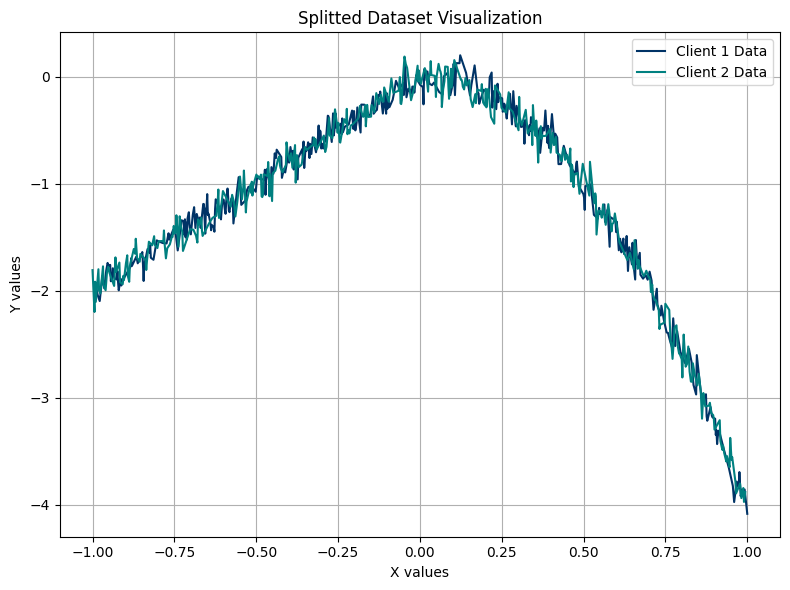

In [ ]:
model_name = f"MyFed_{NUM_CLIENTS}clients_{SPLIT_TYPE}-split"
writer = SummaryWriter(get_logging_dir(model_name, "artificial_1D_linear"))

clients = [
    MultiOutputNet(ARCHITECTURE, INPUT_FEATURES, OUTPUT_FEATURES) for _ in CLIENT_IDs
]

client_train_dataloaders = data.get_client_test_dataloaders(
    NUM_CLIENTS, SPLIT_TYPE, BATCH_SIZE, shuffle=True
)
plot_data_split(client_train_dataloaders, writer)

client_optimizers: list[None | torch.optim.Optimizer] = [None for _ in CLIENT_IDs]


for cr in range(COMMUNICATION_ROUNDS):
    # train each client individually
    for client_no, client in zip(CLIENT_IDs, clients):
        client.train()

        client_optimizers[client_no] = torch.optim.Adam(
            clients[client_no].parameters(), lr=0.001
        )

        # train each client for certain epochs
        for ce in range(CLIENT_EPOCHS):
            losses = []
            for x, y in client_train_dataloaders[client_no]:
                client_optimizers[client_no].zero_grad()
                y_hat = client(x)
                loss = LOSS_FN(y_hat, y)
                loss.backward()
                client_optimizers[client_no].step()

                losses.append(loss.item())

            writer.add_scalar(
                f"loss/client{client_no}",
                sum(losses) / len(losses),
                cr * CLIENT_EPOCHS + ce,
            )

    for client, client_no in zip(clients, CLIENT_IDs):
        writer.add_scalar(f"test_loss/client{client_no}", evaluate(client), cr)

    if cr == COMMUNICATION_ROUNDS - 1:
        global_model = average_models(clients)
    else:
        global_model = combine_two(
            clients[0],
            clients[1],
            similarity_threshold_in_degree=10,
            new_weight_initialization="noise",
        )

    writer.add_scalar("test_loss", evaluate(global_model), cr * CLIENT_EPOCHS)

    #### ----- Unimportant ----- TODO: remove
    from IPython.display import clear_output
    clear_output(wait=True)
    print(f"Communication Round {cr}\{  COMMUNICATION_ROUNDS }")
    print("\r global model: ", global_model.layers, end="")
    #### //// ----- Unimportant -----


    clients = [copy.deepcopy(global_model) for _ in CLIENT_IDs]

    if cr == COMMUNICATION_ROUNDS - 2:
        for client in clients:
            client.freeze_all()
            client.unfreeze_layer(-1)
            client.unfreeze_output_scaling()

plot_predictions(global_model, model_name, writer)
writer.add_hparams(
    {
        "client_epochs": CLIENT_EPOCHS,
        "num_clients": NUM_CLIENTS,
        "communication_rounds": COMMUNICATION_ROUNDS,
        "split_type": SPLIT_TYPE,
    },
    {
        "MSE Test": evaluate(global_model),
    },
    run_name=".",
)
writer.close()